In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 크기
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

In [10]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

In [11]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [12]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [13]:
for i in train_list_ds.take(1):
    print(i)

tf.Tensor(b'/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg', shape=(), dtype=string)


In [14]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113
Training images count: 4185
Validating images count: 1047


In [15]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다.
# 폐렴 예시 : /aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg
# 정상 예시 : /aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
# tf.strings.split 함수는 TensorFlow 라이브러리 내에서 문자열 분할을 수행하는 함수로, 
# GPU나 TPU 같은 가속기를 활용하여 빠른 처리 속도를 보장하려고 최적화되어 있습니다. 
# 또한, TensorFlow의 문자열 텐서를 다룰 때 더욱 유용한 기능들을 제공할 수 있습니다.
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [16]:
# 이미지를 알맞은 형식으로 변경합니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
# PIL을 이용해서 이미지를 읽을수도 있는데, 이렇게 되면 list -> numpy 변형과정이 추가된다.
# 최적의 방법이 바로 tf.io.read인 듯 하다.
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [17]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [18]:
# train_ds.take(1)형식으로 data 1개를 뽑아낼 수 있다.
for image, label in train_ds.take(1):
    print(type(image), type(label))
    print(image.shape, "-image")
    print(label, "-label")
#     print("Image shape: ", image.numpy().shape)
#     print("Label: ", label.numpy())

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(180, 180, 3) -image
tf.Tensor(False, shape=(), dtype=bool) -label


In [19]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

In [20]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


# Dataset 전처리 과정
1. train_list_ds를 `tf.data.Dataset.from_tensor_slices`를 이용해 ['data 경로1', 'data 경로 2'] 이렇게 있는 list를 해당 `tf.Tensor('경로1')`이 나오도록 하는 Generator 형태로 선언함.
2. `train_list_ds`에 map을 적용해 return 되는 것을 `process_path` 의 적용 결과값으로 나오도록 함.(함수형 프로그래밍)

In [21]:
def prepare_for_training(ds, shuffle_buffer_size=10000):
    # 이렇게 작성하는 것을 method channing이라고 하며, 메서드 체이닝을 사용하면 코드가 간결해지고 읽기 쉬워진다고 합니다.
    """
        여기다가 augmentation을 적용할 수 있음.
    """
    ds = ds.shuffle(buffer_size=shuffle_buffer_size).repeat().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#         .repeat()
#         .batch(BATCH_SIZE)
#         .prefetch(buffer_size=AUTOTUNE)
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

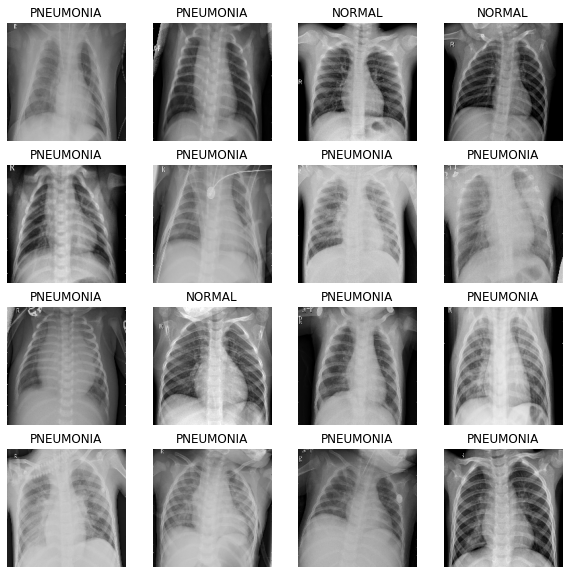

In [22]:
# # 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
# def show_batch(image_batch, label_batch):
#     plt.figure(figsize=(10,10))
#     for n in range(BATCH_SIZE):
#         ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
#         plt.imshow(image_batch[n])
#         if label_batch[n]:
#             plt.title("PNEUMONIA")
#         else:
#             plt.title("NORMAL")
#         plt.axis("off")


# image_batch, label_batch = next(iter(train_ds))
# show_batch(image_batch.numpy(), label_batch.numpy())

# Model Implement

In [76]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class ConvBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size, strides, padding='same'):
        super(ConvBlock, self).__init__()
        self.conv1 = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)
        self.batch_norm = layers.BatchNormalization()
        self.relu = layers.ReLU()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.batch_norm(x)
        x = self.relu(x)
        return x

In [77]:
class IdentityBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(IdentityBlock, self).__init__()
        self.conv1 = layers.Conv2D(filters, 1, padding='same')  # 1x1 컨볼루션 추가
        self.conv_block1 = ConvBlock(filters, kernel_size, strides=1)
        self.conv2 = layers.Conv2D(filters, kernel_size, padding='same')
        self.batch_norm = layers.BatchNormalization()

    def call(self, inputs):
        residual = self.conv1(inputs)  # 1x1 컨볼루션으로 채널 수 맞추기
        x = self.conv_block1(inputs)
        x = self.conv2(x)
        x = self.batch_norm(x)
        x = layers.add([x, residual])
        x = layers.ReLU()(x)
        return x


In [79]:
class ResNet18(tf.keras.Model):
    def __init__(self, input_shape, num_classes=1):
        super(ResNet18, self).__init__()
        self.input_tensor = layers.Input(shape=input_shape)
        self.conv_block = ConvBlock(filters=64, kernel_size=7, strides=2)
        self.max_pool = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')

        self.filters_list = [64, 128, 256, 512]
        self.IdentityBlocks = [
            IdentityBlock(filters=filters, kernel_size=3) for filters in self.filters_list
        ] + [
            IdentityBlock(filters=filters * 2, kernel_size=3) for filters in self.filters_list
        ]  # 채널 수가 바뀌는 두 번째 IdentityBlock은 filters에 2를 곱해줍니다.

        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.dense = layers.Dense(num_classes, activation='sigmoid')

    def call(self, inputs):
        x = self.conv_block(inputs)
        x = self.max_pool(x)

        for block in self.IdentityBlocks:
            x = block(x)

        x = self.global_avg_pool(x)
        x = self.dense(x)

        return x

In [80]:
with tf.device('/GPU:0'):
    input_shape = (180, 180, 3)
    model = ResNet18(input_shape) # Resnet18
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    )

Epoch 1/10
261/261 [==============================] - 295s 732ms/step - loss: 0.2878 - accuracy: 0.8908 - precision: 0.9152 - recall: 0.9405 - val_loss: 0.6469 - val_accuracy: 0.5894 - val_precision: 0.7128 - val_recall: 0.7399
Epoch 2/10
129/261 [=============>................] - ETA: 1:17 - loss: 0.2118 - accuracy: 0.9109 - precision: 0.9358 - recall: 0.9443

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')